# CART segmentation project



In [ ]:
import os
import glob
import gc
import cv2
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input,BatchNormalization
from tensorflow.keras.layers import Conv2D, Conv2DTranspose
from tensorflow.keras.layers import MaxPooling2D, Activation, Dropout
from tensorflow.keras.layers import concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback, ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import nibabel as nib
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/client/session.py:1768: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [ ]:
print(tf.__version__)

2.9.2


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Creat CSV file for X and Y

In [ ]:
base_path='/content/drive/MyDrive/CAR-T/CAR-T_original_mask_trials/dataset_02'
x_folder = base_path + '/original images' + '/train/'
y_foler = base_path+'/mask images' + '/train/'

files_in_image = sorted(os.listdir(x_folder))
files_in_mask = sorted(os.listdir(y_foler))
print(files_in_image)


['C102M4D1_TE12.nii.gz', 'C102M4D1_TE16.nii.gz', 'C102M4D1_TE20.nii.gz', 'C102M4D1_TE24.nii.gz', 'C102M4D1_TE29.nii.gz', 'C102M4D1_TE7.nii.gz', 'C102M4D3_TE12.nii.gz', 'C102M4D3_TE16.nii.gz', 'C102M4D3_TE20.nii.gz', 'C102M4D3_TE24.nii.gz', 'C102M4D3_TE29.nii.gz', 'C102M4D3_TE7.nii.gz', 'C102M4D5_TE12.nii.gz', 'C102M4D5_TE16.nii.gz', 'C102M4D5_TE20.nii.gz', 'C102M4D5_TE24.nii.gz', 'C102M4D5_TE29.nii.gz', 'C102M4D5_TE7.nii.gz', 'C103M1D1_TE12.nii.gz', 'C103M1D1_TE16.nii.gz', 'C103M1D1_TE20.nii.gz', 'C103M1D1_TE25.nii.gz', 'C103M1D1_TE29.nii.gz', 'C103M1D1_TE7.nii.gz', 'C103M1D3_TE12.nii.gz', 'C103M1D3_TE16.nii.gz', 'C103M1D3_TE20.nii.gz', 'C103M1D3_TE25.nii.gz', 'C103M1D3_TE29.nii.gz', 'C103M1D3_TE7.nii.gz', 'C103M1D5_TE12.nii.gz', 'C103M1D5_TE16.nii.gz', 'C103M1D5_TE20.nii.gz', 'C103M1D5_TE25.nii.gz', 'C103M1D5_TE29.nii.gz', 'C103M1D5_TE7.nii.gz', 'C104M2D1_TE12.nii.gz', 'C104M2D1_TE16.nii.gz', 'C104M2D1_TE20.nii.gz', 'C104M2D1_TE25.nii.gz', 'C104M2D1_TE29.nii.gz', 'C104M2D1_TE7.nii.gz'

In [ ]:
images=[i for i in files_in_image if i in files_in_mask]

train_df = pd.DataFrame()
train_df['images']=[x_folder +str(x) for x in images]
train_df['labels']=[y_foler+str(x) for x in images]

train_df.to_csv('files_path.csv')
train_df.shape

(84, 2)

In [ ]:
x_folder = base_path + '/original images' + '/validation/'
y_foler = base_path+'/mask images' + '/validation/'

files_in_image = sorted(os.listdir(x_folder))
files_in_mask = sorted(os.listdir(y_foler))
images=[i for i in files_in_image if i in files_in_mask]

validation_df = pd.DataFrame()
validation_df['images']=[x_folder +str(x) for x in images]
validation_df['labels']=[y_foler+str(x) for x in images]
validation_df.shape

(18, 2)

In [ ]:
def load_image(img_path):
        print(img_path)
        img = nib.load(img_path)    #img = pydicom.read_file(dicom_image)
        img_array = np.array(img.dataobj)   #arry = img.pixel_array
        #img_norm = img_array.astype(np.float32)/255
        #print("Shape: ", img_norm.shape)
        #img_size = cv2.resize(img_norm, (256,256), interpolation=cv2.INTER_NEAREST)

        return img_array #img_norm

In [ ]:
n_channels = 22

/content/drive/MyDrive/CAR-T/CAR-T_original_mask_trials/dataset_02/original images/validation/C113M3D1_TE12.nii.gz
/content/drive/MyDrive/CAR-T/CAR-T_original_mask_trials/dataset_02/mask images/validation/C113M3D1_TE12.nii.gz


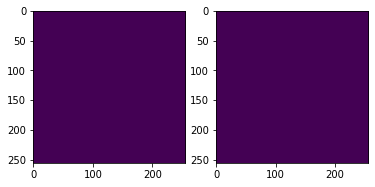

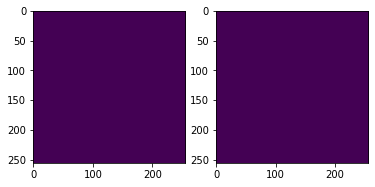

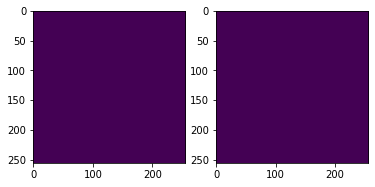

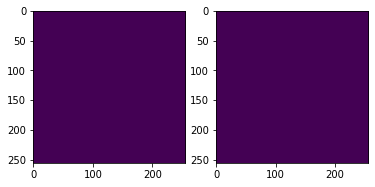

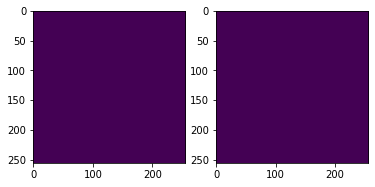

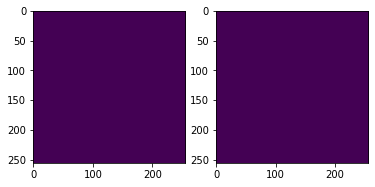

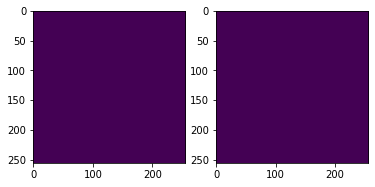

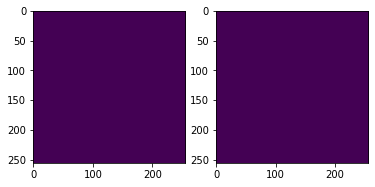

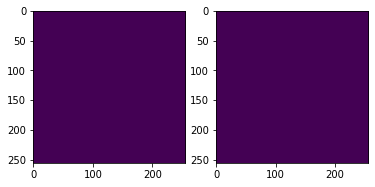

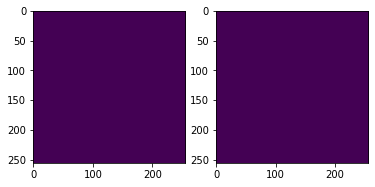

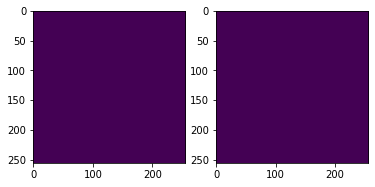

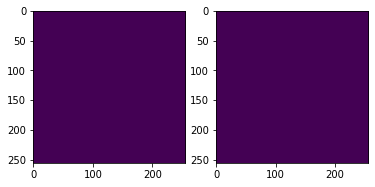

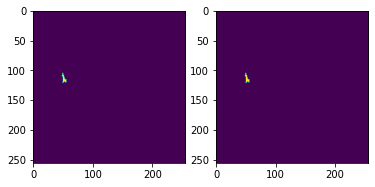

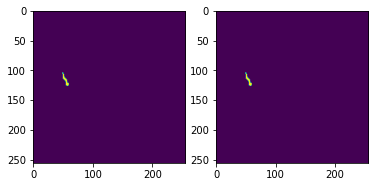

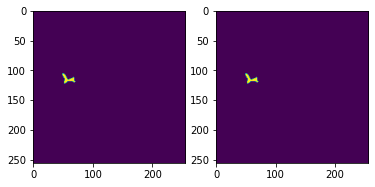

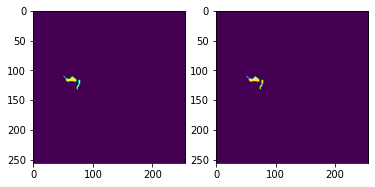

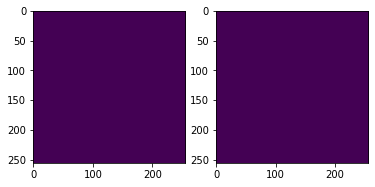

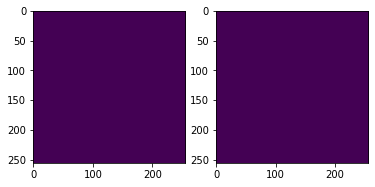

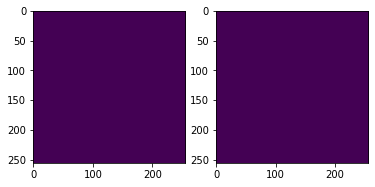

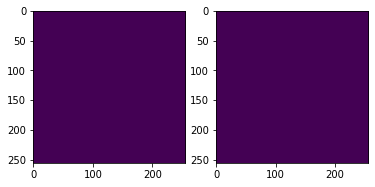

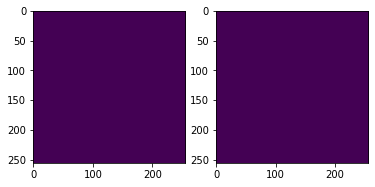

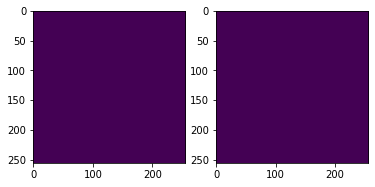

In [ ]:
#'''
for ID in range(0,1): # len(validation_df)):
  img_path = validation_df['images'].iloc[ID]
  img = load_image(img_path)
  msk_path = validation_df['labels'].iloc[ID]
  msk = load_image(msk_path)

  for channel in range(0,n_channels):
    x = img[:,:,channel] #.reshape(256,256,1)
    y = msk[:,:,channel] #.reshape(256,256,1)
    y = np.where(y0 != 0, 1, y0)
    plt.subplot(121)
    imgplot = plt.imshow(x.squeeze())
    plt.subplot(122)
    imgplot = plt.imshow(y.squeeze())
    plt.show()

#'''

In [ ]:
'''
for ID in range(0,len(train_df)):
  img_path = train_df['images'].iloc[ID]
  img = load_image(img_path)
  msk_path = train_df['labels'].iloc[ID]
  msk = load_image(msk_path)

  for channel in range(0,n_channels):
    x = img[:,:,channel].reshape(256,256,1)
    y0 = msk[:,:,channel].reshape(256,256,1)
    y = np.where(y0 != 0, 1, y0)
    plt.subplot(121)
    imgplot = plt.imshow(x.squeeze())
    plt.subplot(122)
    imgplot = plt.imshow(y.squeeze())
    plt.show()
    for i in y:
      for j in i:
          if j !=0 :
            print(j, end = ' ')

'''

"\nfor ID in range(0,len(train_df)):\n  img_path = train_df['images'].iloc[ID]\n  img = load_image(img_path)\n  msk_path = train_df['labels'].iloc[ID]\n  msk = load_image(msk_path)\n\n  for channel in range(0,n_channels):\n    x = img[:,:,channel].reshape(256,256,1)\n    y0 = msk[:,:,channel].reshape(256,256,1)\n    y = np.where(y0 != 0, 1, y0)\n    plt.subplot(121)\n    imgplot = plt.imshow(x.squeeze())\n    plt.subplot(122)\n    imgplot = plt.imshow(y.squeeze())\n    plt.show()\n    for i in y:\n      for j in i:  \n          if j !=0 : \n            print(j, end = ' ')\n\n"

## Data Generater

In [ ]:
class DataGenerator(keras.utils.Sequence):
    def __init__(self, list_IDs, df, mode='fit',
                 base_path='CAR-T/CAR-T_original_mask_02',
                 n_channels=22, batch_size=8, random_state=2021, shuffle=True):
        self.list_IDs = list_IDs
        self.df = df
        self.batch_size = batch_size
        self.mode = mode
        self.base_path = base_path
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.random_state = random_state

        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        #print("number of batches per epoch: ", int(np.ceil(len(self.list_IDs) / self.batch_size)))

        return int(np.ceil(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        #print("getitem indexes: ", indexes, end = "  ")
        list_IDs_batch = [self.list_IDs[k] for k in indexes]
        #print(" list_IDs_batch: ",  list_IDs_batch )

        x = np.empty((self.batch_size*self.n_channels,256,256,1))
        y = np.empty((self.batch_size*self.n_channels,256,256,1))
        #print("create empty x, shape", x.shape)
        #print("create empty y, shape", y.shape)

        j = 0
        for i, ID in enumerate(list_IDs_batch):
            img_path = self.df['images'].iloc[ID]
            img = self.__load_image(img_path)
            if self.mode == 'fit':
              msk_path = self.df['labels'].iloc[ID]
              msk = self.__load_mask(msk_path)

            # Store samples
            for channel in range(0,self.n_channels):
                x0 = img[:,:,channel].reshape(256,256,1)
                #y[j] = msk[:,:,channel].reshape(256,256,1)
                if self.mode == 'fit':
                  y0 = msk[:,:,channel].reshape(256,256,1)
                  if np.sum(y0) > 0:
                    y[j] = np.where(y0 > 0, 1, y0)
                    x[j] = x0
                    j += 1
                else: # add process for predict
                  x[j] = x0
                  j += 1

        #print("Getitem - Total image:", j)

        if self.mode == 'fit':
            return x[0:j], y[0:j]

        elif self.mode == 'predict':
            return x

        else:
            raise AttributeError('The mode parameter should be set to "fit" or "predict".')


    def __load_image(self, img_path):
        #print(img_path)
        img = nib.load(img_path)    #img = pydicom.read_file(dicom_image)
        img_array = np.array(img.dataobj)   #arry = img.pixel_array
        img_norm = img_array.astype(np.float32)/255
        #print("Shape: ", img_norm.shape)
        img_size = cv2.resize(img_norm, (256,256), interpolation=cv2.INTER_NEAREST)
        return img_size  #img_norm

    def __load_mask(self, img_path):
        #print(img_path)
        img = nib.load(img_path)    #img = pydicom.read_file(dicom_image)
        img_array = np.array(img.dataobj)   #arry = img.pixel_array
        #img_norm = img_array.astype(np.float32)/255
        #print("Shape: ", img_norm.shape)
        img_size = cv2.resize(img_array, (256,256), interpolation=cv2.INTER_NEAREST)
        return img_size

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        #self.indexes = np.arange(len(self.df))
        #print("One epoce ended!")
        if self.shuffle == True:
            np.random.seed(self.random_state)
            np.random.shuffle(self.indexes)


In [ ]:
def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

In [ ]:
def conv2d_block(input_tensor, n_filters, kernel_size=3, batchnorm=True):
    # first layer
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal",
               padding="same")(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation("relu")(x)
    # second layer
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal",
               padding="same")(x)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x

# Model

In [ ]:
from pandas.core.base import NoNewAttributesMixin
def get_unet(input_img, n_filters=16, batchnorm=True):
    # contracting path
    c1 = conv2d_block(input_img, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm)
    p1 = MaxPooling2D(2)(c1)

    c2 = conv2d_block(p1, n_filters=n_filters*2, kernel_size=3, batchnorm=batchnorm)
    p2 = MaxPooling2D((2, 2)) (c2)


    c3 = conv2d_block(p2, n_filters=n_filters*4, kernel_size=3, batchnorm=batchnorm)
    p3 = MaxPooling2D((2, 2)) (c3)

    c4 = conv2d_block(p3, n_filters=n_filters*8, kernel_size=3, batchnorm=batchnorm)
    p4 = MaxPooling2D(pool_size=(2, 2)) (c4)


    c5 = conv2d_block(p4, n_filters=n_filters*16, kernel_size=3, batchnorm=batchnorm)

    # expansive path
    u6 = Conv2DTranspose(n_filters*8, (3, 3), strides=(2, 2), padding='same') (c5)
    u6 = concatenate([u6, c4])
    c6 = conv2d_block(u6, n_filters=n_filters*8, kernel_size=3, batchnorm=batchnorm)

    u7 = Conv2DTranspose(n_filters*4, (3, 3), strides=(2, 2), padding='same') (c6)
    u7 = concatenate([u7, c3])
    c7 = conv2d_block(u7, n_filters=n_filters*4, kernel_size=3, batchnorm=batchnorm)

    u8 = Conv2DTranspose(n_filters*2, (3, 3), strides=(2, 2), padding='same') (c7)
    u8 = concatenate([u8, c2])
    c8 = conv2d_block(u8, n_filters=n_filters*2, kernel_size=3, batchnorm=batchnorm)

    u9 = Conv2DTranspose(n_filters*1, (3, 3), strides=(2, 2), padding='same') (c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = conv2d_block(u9, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm)

    outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9) #outputs = Conv2D(4, (1, 1), activation='sigmoid') (c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

In [ ]:
input_img = Input((256, 256, 1), name='img')
model = get_unet(input_img, n_filters=16, batchnorm=True)

#model = get_unet(input_img, n_filters=16, dropout=0.5, batchnorm=True)

#build_model((256, 1600, 1))
#model.summary()

In [ ]:

'''
train_idx, val_idx = train_test_split(
    train_df.index,
    random_state=2021,
    test_size=0.2
)
'''

BATCH_SIZE = 5

train_idx =train_df.index
train_generator = DataGenerator(
    train_idx,
    df=train_df,
    #target_df=df,
    batch_size=BATCH_SIZE,
    n_channels = 22
)

val_idx = validation_df.index
val_generator = DataGenerator(
    val_idx,
    df=validation_df,
    #target_df=test_df,
    batch_size=BATCH_SIZE,
    n_channels = 22
)

In [ ]:
def weighted_bce(y_true, y_pred):
  weights = (y_true * 59.) + 1.
  bce = K.binary_crossentropy(y_true, y_pred)
  weighted_bce = K.mean(bce * weights)
  return weighted_bce

In [ ]:
mc = ModelCheckpoint(
    'model.h5',
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    save_weights_only=False,
    mode='auto'
)

es = EarlyStopping(monitor='val_loss', mode='min', verbose=2, patience=100)
model.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=[dice_coef])
#model.compile(optimizer=Adam(), loss=weighted_bce, metrics=[dice_coef])



history = model.fit(
    train_generator,
    validation_data=val_generator,

    callbacks=[mc,es],
    verbose=2,
    epochs=200
)

Epoch 1/200

Epoch 1: val_loss improved from inf to 0.63534, saving model to model.h5
17/17 - 254s - loss: 0.3713 - dice_coef: 0.0075 - val_loss: 0.6353 - val_dice_coef: 0.0045 - 254s/epoch - 15s/step
Epoch 2/200

Epoch 2: val_loss improved from 0.63534 to 0.48819, saving model to model.h5
17/17 - 8s - loss: 0.2051 - dice_coef: 0.0092 - val_loss: 0.4882 - val_dice_coef: 0.0045 - 8s/epoch - 461ms/step
Epoch 3/200

Epoch 3: val_loss improved from 0.48819 to 0.29555, saving model to model.h5
17/17 - 8s - loss: 0.1528 - dice_coef: 0.0086 - val_loss: 0.2956 - val_dice_coef: 0.0045 - 8s/epoch - 468ms/step
Epoch 4/200

Epoch 4: val_loss improved from 0.29555 to 0.19791, saving model to model.h5
17/17 - 8s - loss: 0.1217 - dice_coef: 0.0088 - val_loss: 0.1979 - val_dice_coef: 0.0045 - 8s/epoch - 474ms/step
Epoch 5/200

Epoch 5: val_loss improved from 0.19791 to 0.15982, saving model to model.h5
17/17 - 8s - loss: 0.1006 - dice_coef: 0.0104 - val_loss: 0.1598 - val_dice_coef: 0.0044 - 8s/epoch 

In [ ]:
def history_plot(model_id, history1):
	plt.figure(figsize=(14,16))
	# plot loss
	plt.subplot(2, 1, 1)
	plt.title('Cross Entropy Loss - ' + model_id, fontsize = 12)
	plt.plot(history1.history['loss'], color='blue', label='train base')
	plt.plot(history1.history['val_loss'], color='cyan', label='val base')
	plt.xlabel("Epochs",fontsize = 12)
	plt.ylabel("Loss", fontsize = 12)
	plt.legend(loc='upper right')

	# plot accuracy
	plt.subplot(2, 1, 2)
	plt.title('Classification Accuracy ' + model_id, fontsize = 10)
	plt.plot(history1.history['dice_coef'], color='blue', label='train base')
	plt.plot(history1.history['val_dice_coef'], color='cyan', label='val base')
	plt.xlabel("Epochs", fontsize = 12)
	plt.ylabel("dice_coef", fontsize = 12)
	plt.legend(loc='lower right')

	plt.show()

In [ ]:
history.history.keys()

dict_keys(['loss', 'dice_coef', 'val_loss', 'val_dice_coef'])

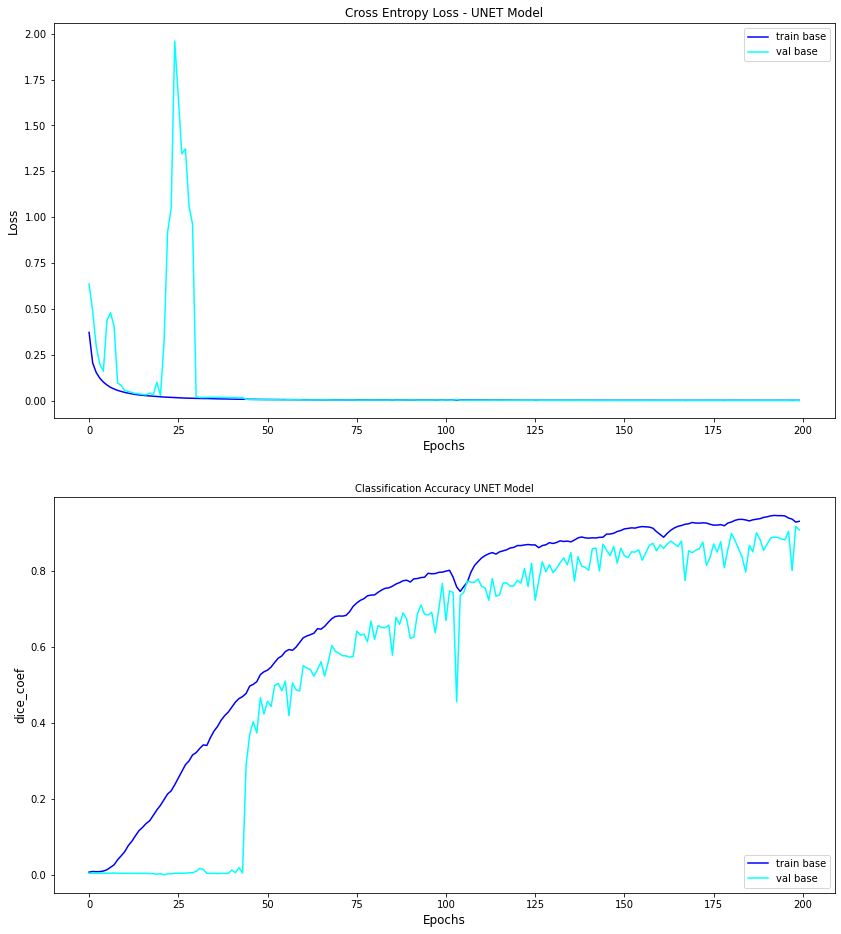

In [ ]:
history_plot('UNET Model', history)

In [ ]:
model.load_weights('model.h5')

In [ ]:
model.save("/content/drive/MyDrive/CAR-T/CAR-T_original_mask_trials/dataset_02_model2021113.h5", save_format="h5" )

In [ ]:
import os

In [ ]:
os.listdir("/content/drive/MyDrive/CAR-T/CAR-T_original_mask_trials/")

['dataset_01',
 'dataset_03',
 'dataset_05',
 'dataset_06',
 'dataset_02',
 'dataset_04',
 'dataset.xlsx',
 'dataset_02_model2021113.h5']

In [ ]:
dependencies = {
    'dice_coef': dice_coef
}

custom_objects=dependencies

model = load_model('/content/drive/MyDrive/CAR-T/CAR-T_original_mask_trials/dataset_02_model2021113.h5',
                   custom_objects=dependencies)

In [ ]:
#base_path='/content/drive/MyDrive/CAR-T_AI/CAR-T_original_mask_trials/dataset_022'
base_path='/content/drive/MyDrive/CAR-T/CAR-T_original_mask_trials/dataset_02'
x_folder = base_path + '/original images' + '/test/'
y_foler = base_path+'/mask images' + '/test/'

files_in_image = sorted(os.listdir(x_folder))
print(files_in_image)


['C101M4D1_TE12.nii.gz', 'C101M4D1_TE16.nii.gz', 'C101M4D1_TE20.nii.gz', 'C101M4D1_TE25.nii.gz', 'C101M4D1_TE29.nii.gz', 'C101M4D1_TE7.nii.gz', 'C101M4D3_TE12.nii.gz', 'C101M4D3_TE16.nii.gz', 'C101M4D3_TE20.nii.gz', 'C101M4D3_TE25.nii.gz', 'C101M4D3_TE29.nii.gz', 'C101M4D3_TE7.nii.gz', 'C101M4D5_TE12.nii.gz', 'C101M4D5_TE16.nii.gz', 'C101M4D5_TE20.nii.gz', 'C101M4D5_TE24.nii.gz', 'C101M4D5_TE29.nii.gz', 'C101M4D5_TE7.nii.gz']


In [ ]:
images=[i for i in files_in_image]

test_df = pd.DataFrame()
test_df['images']=[x_folder +str(x) for x in images]
test_df['labels']=[y_foler+str(x) for x in images]

test_df

images  \
0   /content/drive/MyDrive/CAR-T/CAR-T_original_ma...   
1   /content/drive/MyDrive/CAR-T/CAR-T_original_ma...   
2   /content/drive/MyDrive/CAR-T/CAR-T_original_ma...   
3   /content/drive/MyDrive/CAR-T/CAR-T_original_ma...   
4   /content/drive/MyDrive/CAR-T/CAR-T_original_ma...   
5   /content/drive/MyDrive/CAR-T/CAR-T_original_ma...   
6   /content/drive/MyDrive/CAR-T/CAR-T_original_ma...   
7   /content/drive/MyDrive/CAR-T/CAR-T_original_ma...   
8   /content/drive/MyDrive/CAR-T/CAR-T_original_ma...   
9   /content/drive/MyDrive/CAR-T/CAR-T_original_ma...   
10  /content/drive/MyDrive/CAR-T/CAR-T_original_ma...   
11  /content/drive/MyDrive/CAR-T/CAR-T_original_ma...   
12  /content/drive/MyDrive/CAR-T/CAR-T_original_ma...   
13  /content/drive/MyDrive/CAR-T/CAR-T_original_ma...   
14  /content/drive/MyDrive/CAR-T/CAR-T_original_ma...   
15  /content/drive/MyDrive/CAR-T/CAR-T_original_ma...   
16  /content/drive/MyDrive/CAR-T/CAR-T_original_ma...   
17  /content/drive/MyDrive/CAR-T/CAR-T_original_ma...   

                                               labels  
0   /content/drive/MyDrive/CAR-T/CAR-T_original_ma...  
1   /content/drive/MyDrive/CAR-T/CAR-T_original_ma...  
2   /content/drive/MyDrive/CAR-T/CAR-T_original_ma...  
3   /content/drive/MyDrive/CAR-T/CAR-T_original_ma...  
4   /content/drive/MyDrive/CAR-T/CAR-T_original_ma...  
5   /content/drive/MyDrive/CAR-T/CAR-T_original_ma...  
6   /content/drive/MyDrive/CAR-T/CAR-T_original_ma...  
7   /content/drive/MyDrive/CAR-T/CAR-T_original_ma...  
8   /content/drive/MyDrive/CAR-T/CAR-T_original_ma...  
9   /content/drive/MyDrive/CAR-T/CAR-T_original_ma...  
10  /content/drive/MyDrive/CAR-T/CAR-T_original_ma...  
11  /content/drive/MyDrive/CAR-T/CAR-T_original_ma...  
12  /content/drive/MyDrive/CAR-T/CAR-T_original_ma...  
13  /content/drive/MyDrive/CAR-T/CAR-T_original_ma...  
14  /content/drive/MyDrive/CAR-T/CAR-T_original_ma...  
15  /content/drive/MyDrive/CAR-T/CAR-T_original_ma...  
16  /content/drive/MyDrive/CAR-T/CAR-T_original_ma...  
17  /content/drive/MyDrive/CAR-T/CAR-T_original_ma...

In [ ]:
test_idx = test_df.index
test_generator = DataGenerator(
    test_idx,
    df=test_df,
    shuffle=False,
    mode ='predict',
    batch_size=1,
    n_channels = 22
)

#model = tf.keras.models.load_model("/content/CART_UNET_0.9.h5")

prediction = model.predict(
            test_generator,
            verbose=1,
            )




18/18 [==============================] - 1s 75ms/step


In [ ]:
len(prediction)

396

In [ ]:
 def load_image(img_path):
        #print(img_path)
        img = nib.load(img_path)    #img = pydicom.read_file(dicom_image)
        img_array = np.array(img.dataobj)   #arry = img.pixel_array
        img_norm = img_array.astype(np.float32)/255
        #print("Shape: ", img_norm.shape)
        img_size = cv2.resize(img_norm, (256,256), interpolation=cv2.INTER_NEAREST)
        return img_array#  img_size  #img_norm

 def load_mask(img_path):
        #print(img_path)
        img = nib.load(img_path)    #img = pydicom.read_file(dicom_image)
        img_array = np.array(img.dataobj)   #arry = img.pixel_array
        #img_norm = img_array.astype(np.float32)/255
        #print("Shape: ", img_norm.shape)
        img_size = cv2.resize(img_array, (256,256), interpolation=cv2.INTER_NEAREST)
        return img_array #img_size


In [ ]:

def image_normalization(img, img_min=0, img_max=255):
    """数据正则化,将数据从一个小范围变换到另一个范围
        默认参数：从（0,1） -> (0,255)

    :param img: 输入数据
    :param img_min: 数据最小值
    :param img_max: 数据最大值
    :return: 返回变换后的结果结果
    """
    img = np.float32(img)
    epsilon = 1e-12
    img = (img - np.min(img)) * (img_max - img_min) / ((np.max(img) - np.min(img)) + epsilon) + img_min

    return img


In [ ]:
def show_mask_image(img, mask, mask_pred):
    # 将图片的值从一个小范围 转换到大范围
    img = image_normalization(img)
    # 改为uint8型
    img = img.astype('uint8')
    mask = mask.astype('uint8')
    mask_pred = mask_pred.astype('uint8')


    img0 = np.zeros((256,256,3) )
    img0[:,:,0] = img
    img0[:,:,1] = img
    img0[:,:,2] = img
    cv2.imwrite("tmp.jpg", img0)
    img = cv2.imread("tmp.jpg",cv2.IMREAD_UNCHANGED)

    mask = np.where(mask != 0, 1, mask)
    mask_pred = np.where(mask_pred != 0, 1, mask_pred)


    plt.figure(1, figsize=(15, 15))
    plt.subplot(131)
    imgplot = plt.imshow(img)

    plt.subplot(132)
    img_GT = cv2.imread("tmp.jpg",cv2.IMREAD_UNCHANGED)
    contours, _ = cv2.findContours(mask, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
    for i in range(0, len(contours)):
        cv2.polylines(img_GT, contours[i], True, palet[0], 2)
    imgplot = plt.imshow(img_GT)

    plt.subplot(133)
    img_Pred = cv2.imread("tmp.jpg",cv2.IMREAD_UNCHANGED)
    contours_pred, _ = cv2.findContours(mask_pred, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
    for i in range(0, len(contours_pred)):
        cv2.polylines(img_Pred, contours_pred[i], True, palet[0], 2)
    imgplot = plt.imshow(img_Pred)


    plt.show()


In [ ]:
palet = [(249,50,12),(249, 192, 12), (0, 185, 241), (114, 0, 218)]

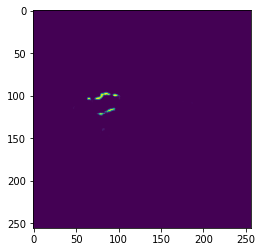

In [ ]:
prediction[0].reshape(256,256).shape,type(prediction[0].reshape(256,256))

/content/drive/MyDrive/CAR-T/CAR-T_original_mask_trials/dataset_02/original images/test/C101M4D1_TE12.nii.gz
Cahnnel: 0
Cahnnel: 1
Cahnnel: 2
Cahnnel: 3
Cahnnel: 4
Cahnnel: 5
Cahnnel: 6
Cahnnel: 7
Cahnnel: 8
6


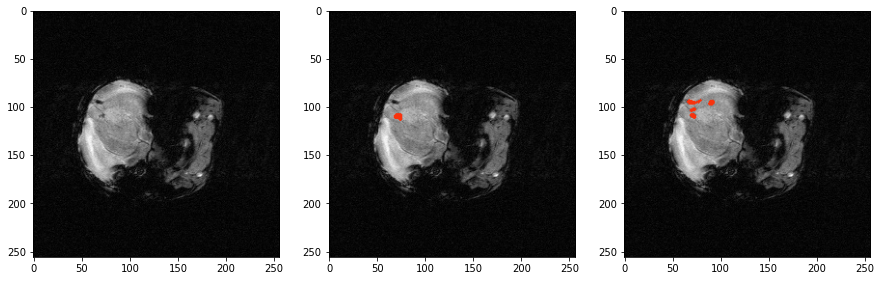

Cahnnel: 9
7


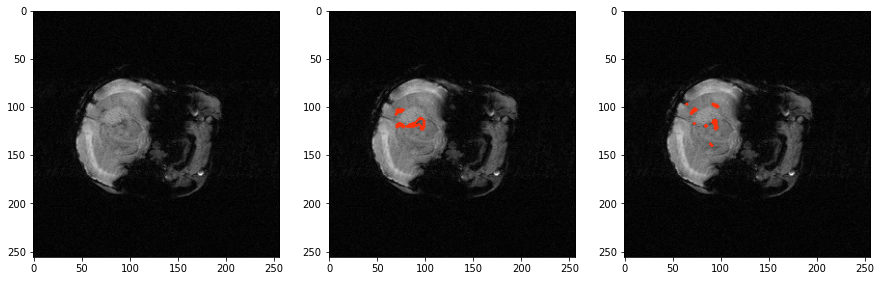

Cahnnel: 10
6


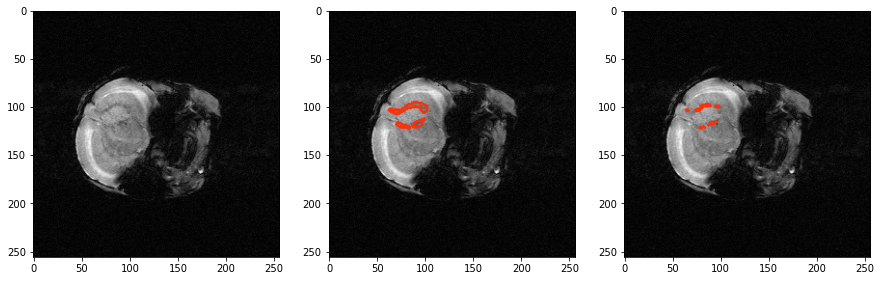

Cahnnel: 11
4


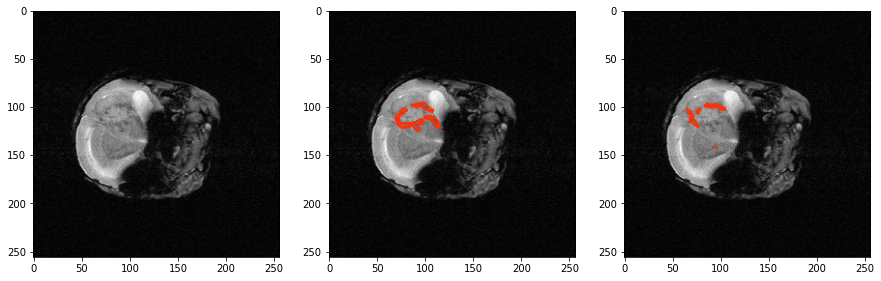

Cahnnel: 12
4


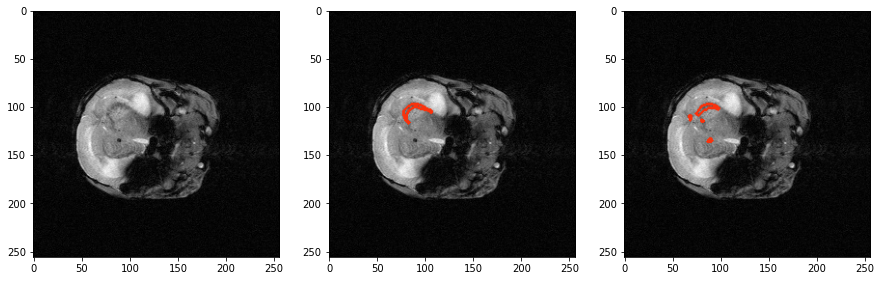

Cahnnel: 13
Cahnnel: 14
Cahnnel: 15
Cahnnel: 16
Cahnnel: 17
Cahnnel: 18
Cahnnel: 19
Cahnnel: 20
Cahnnel: 21
/content/drive/MyDrive/CAR-T/CAR-T_original_mask_trials/dataset_02/original images/test/C101M4D1_TE16.nii.gz
Cahnnel: 0
Cahnnel: 1
Cahnnel: 2
Cahnnel: 3
Cahnnel: 4
Cahnnel: 5
Cahnnel: 6
Cahnnel: 7
Cahnnel: 8
5


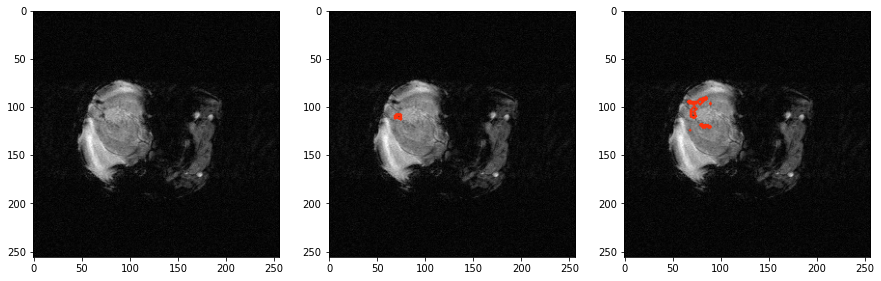

Cahnnel: 9
5


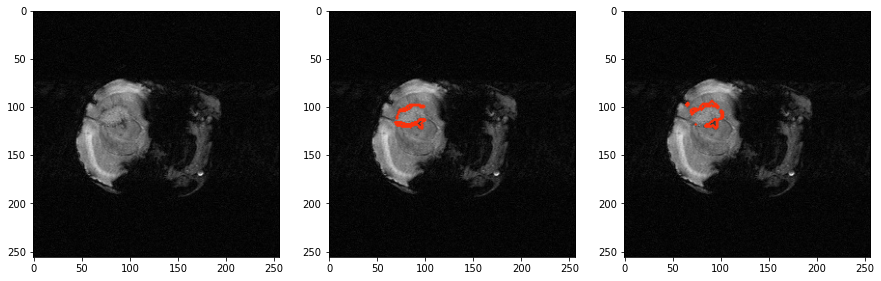

Cahnnel: 10
3


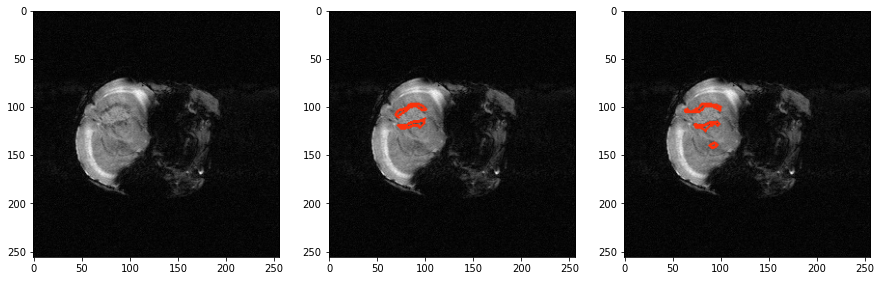

Cahnnel: 11
1


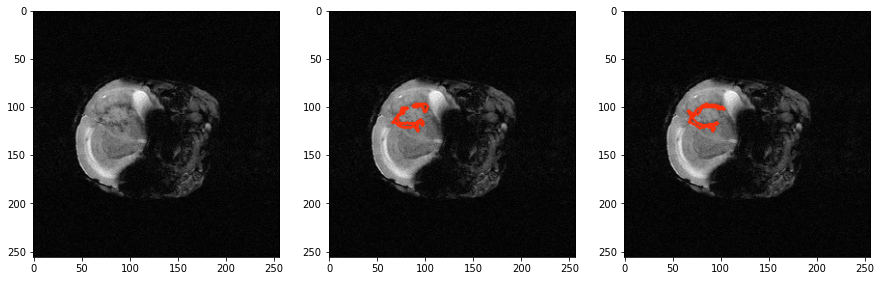

Cahnnel: 12
5


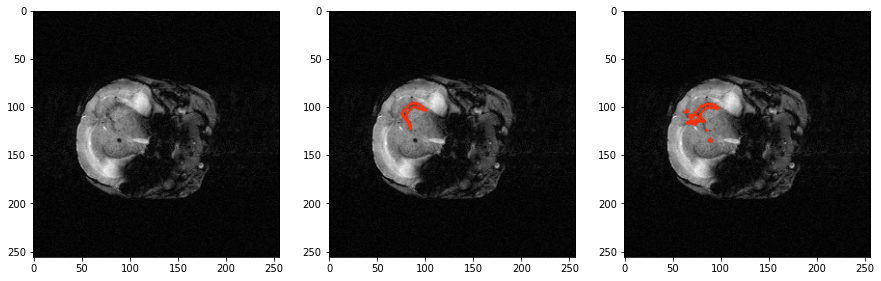

Cahnnel: 13
Cahnnel: 14
Cahnnel: 15
Cahnnel: 16
Cahnnel: 17
Cahnnel: 18
Cahnnel: 19
Cahnnel: 20
Cahnnel: 21
/content/drive/MyDrive/CAR-T/CAR-T_original_mask_trials/dataset_02/original images/test/C101M4D1_TE20.nii.gz
Cahnnel: 0
Cahnnel: 1
Cahnnel: 2
Cahnnel: 3
Cahnnel: 4
Cahnnel: 5
Cahnnel: 6
Cahnnel: 7
Cahnnel: 8
6


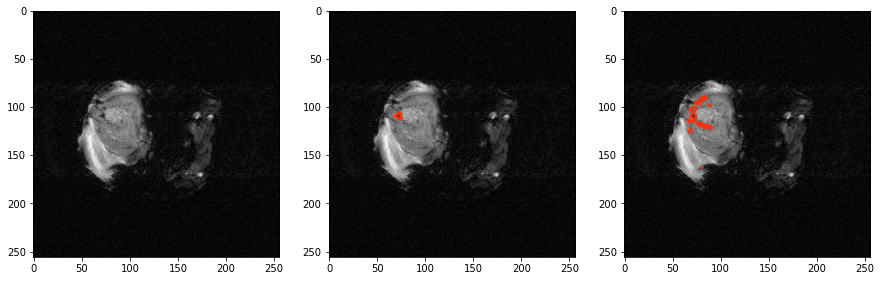

Cahnnel: 9
3


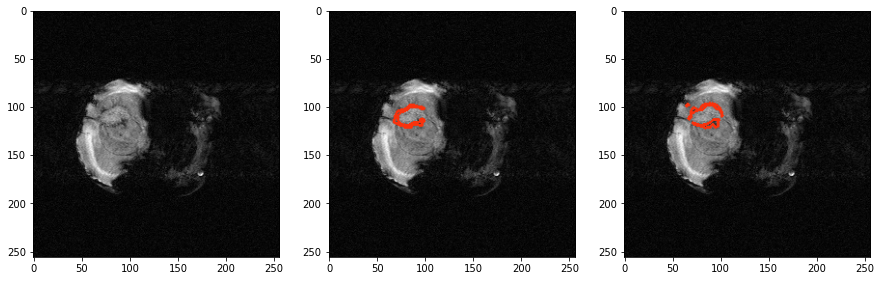

Cahnnel: 10
7


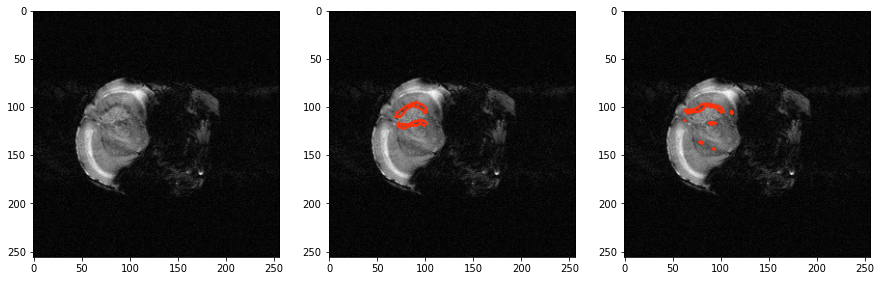

Cahnnel: 11
4


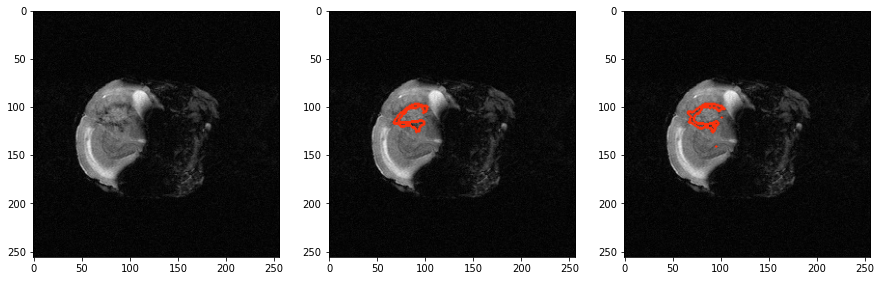

Cahnnel: 12
5


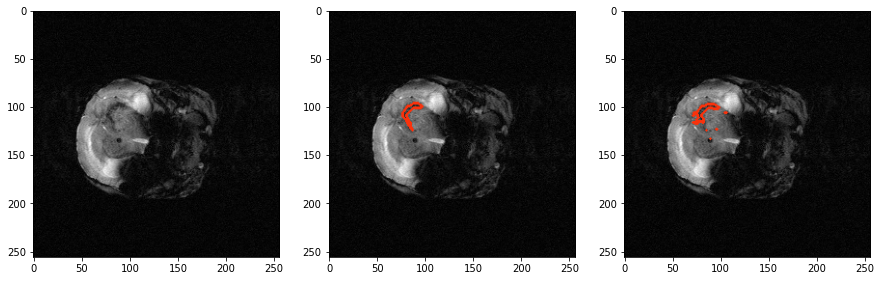

Cahnnel: 13
Cahnnel: 14
Cahnnel: 15
Cahnnel: 16
Cahnnel: 17
Cahnnel: 18
Cahnnel: 19
Cahnnel: 20
Cahnnel: 21
/content/drive/MyDrive/CAR-T/CAR-T_original_mask_trials/dataset_02/original images/test/C101M4D1_TE25.nii.gz
Cahnnel: 0
Cahnnel: 1
Cahnnel: 2
Cahnnel: 3
Cahnnel: 4
Cahnnel: 5
Cahnnel: 6
Cahnnel: 7
Cahnnel: 8
7


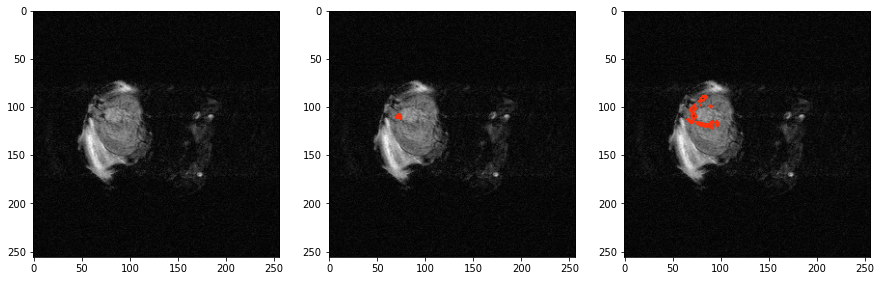

Cahnnel: 9
2


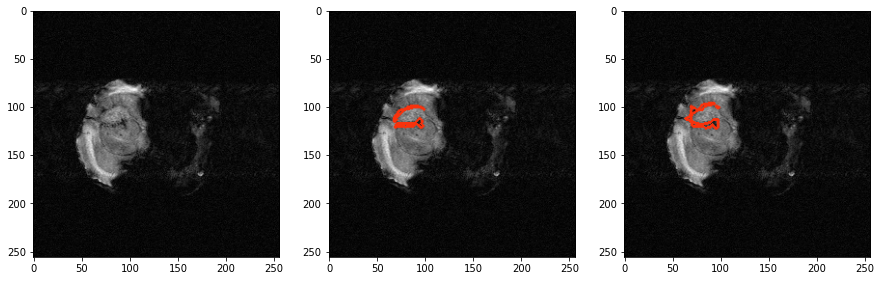

Cahnnel: 10
4


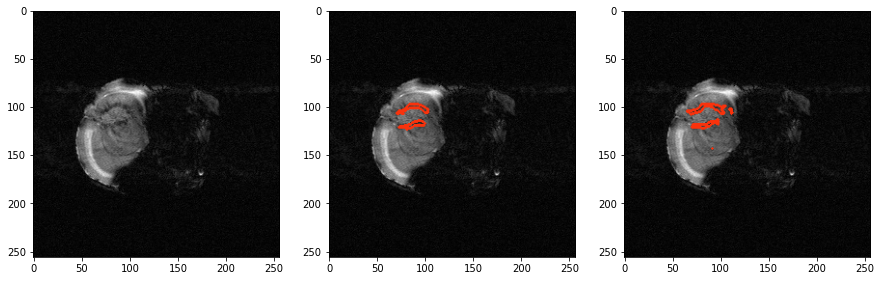

Cahnnel: 11
4


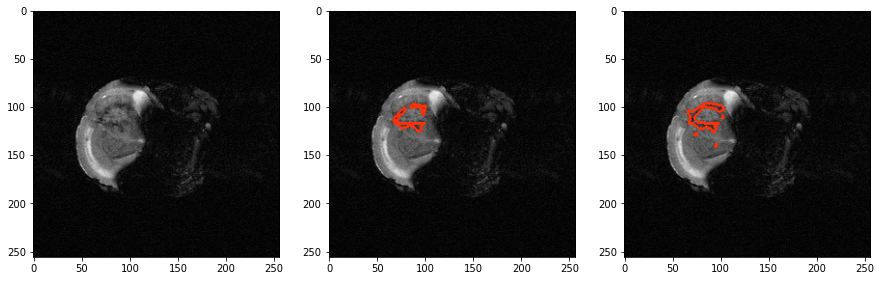

Cahnnel: 12
5


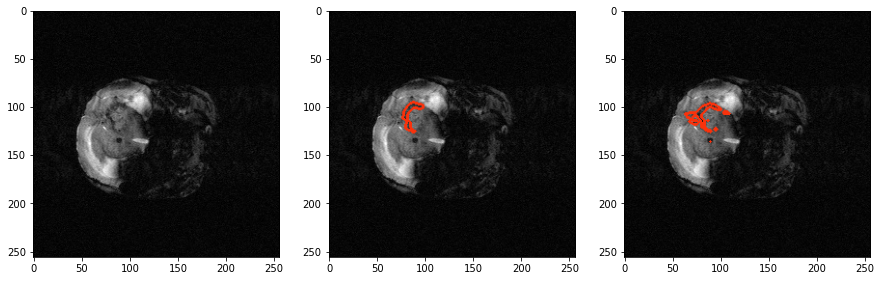

Cahnnel: 13
Cahnnel: 14
Cahnnel: 15
Cahnnel: 16
Cahnnel: 17
Cahnnel: 18
Cahnnel: 19
Cahnnel: 20
Cahnnel: 21
/content/drive/MyDrive/CAR-T/CAR-T_original_mask_trials/dataset_02/original images/test/C101M4D1_TE29.nii.gz
Cahnnel: 0
Cahnnel: 1
Cahnnel: 2
Cahnnel: 3
Cahnnel: 4
Cahnnel: 5
Cahnnel: 6
Cahnnel: 7
Cahnnel: 8
4


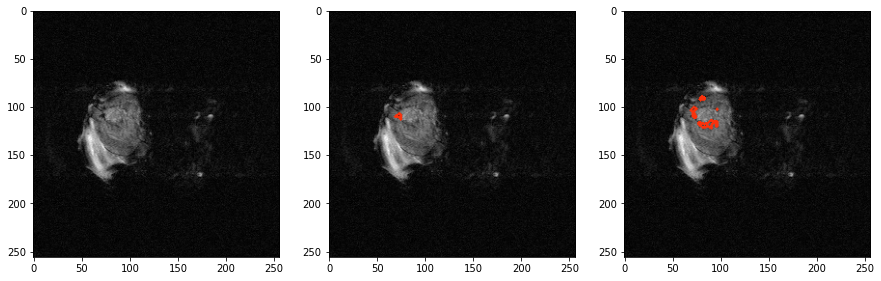

Cahnnel: 9
3


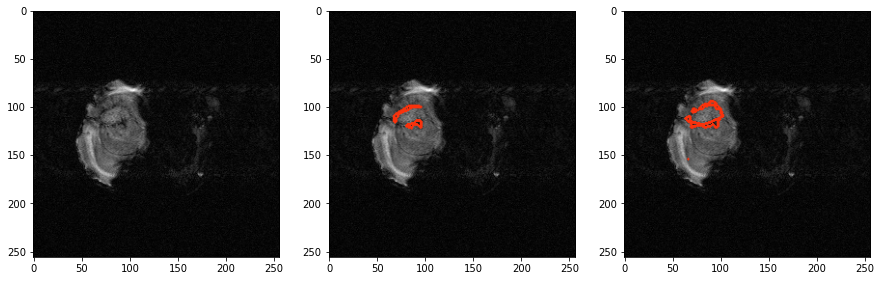

Cahnnel: 10
4


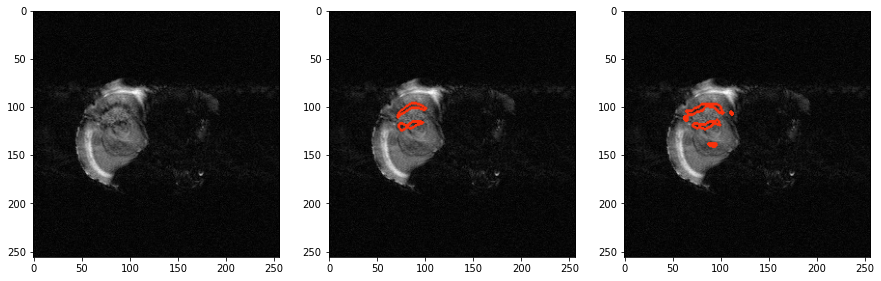

Cahnnel: 11
2


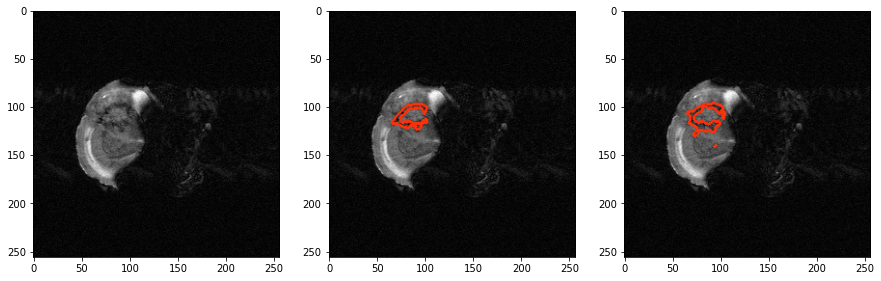

Cahnnel: 12
4


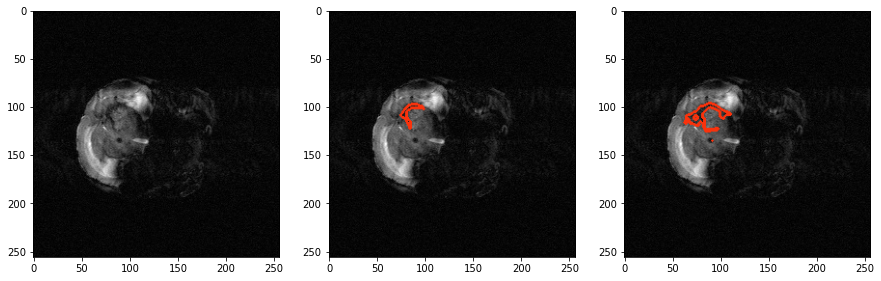

Cahnnel: 13
Cahnnel: 14
Cahnnel: 15
Cahnnel: 16
Cahnnel: 17
Cahnnel: 18
Cahnnel: 19
Cahnnel: 20
Cahnnel: 21
/content/drive/MyDrive/CAR-T/CAR-T_original_mask_trials/dataset_02/original images/test/C101M4D1_TE7.nii.gz
Cahnnel: 0
Cahnnel: 1
Cahnnel: 2
Cahnnel: 3
Cahnnel: 4
Cahnnel: 5
Cahnnel: 6
Cahnnel: 7
Cahnnel: 8
2


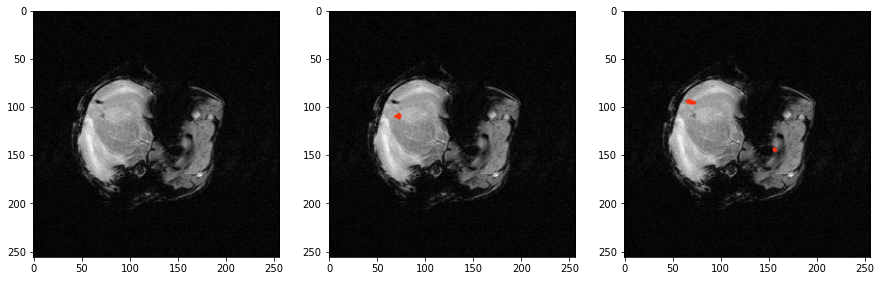

Cahnnel: 9
5


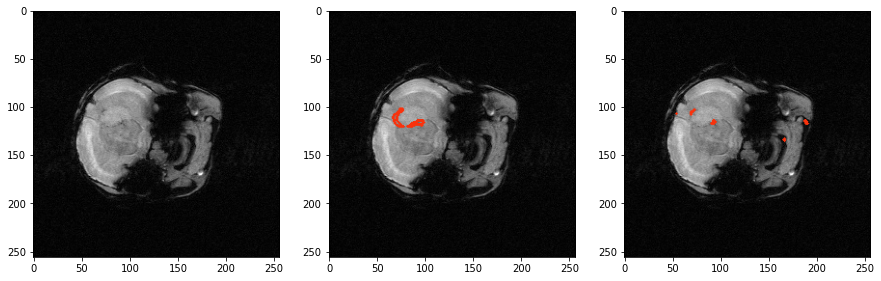

Cahnnel: 10
6


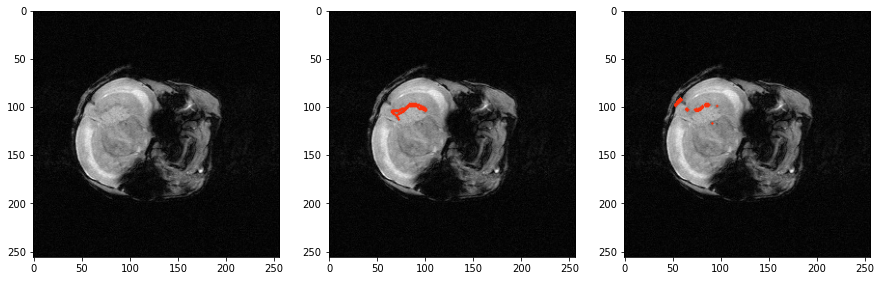

Cahnnel: 11
5


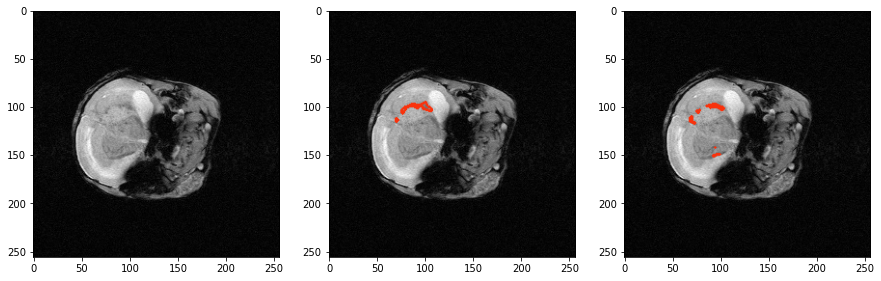

Cahnnel: 12
2


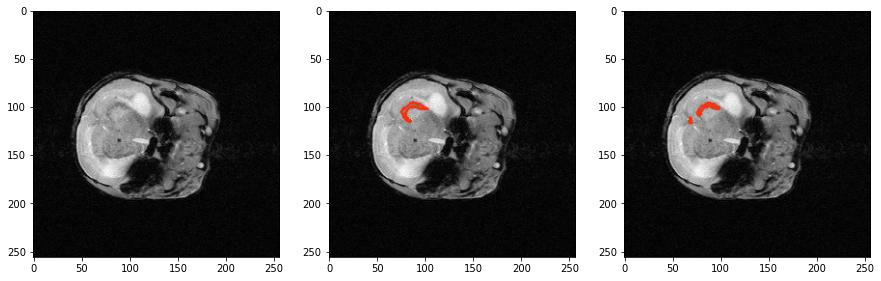

Cahnnel: 13
Cahnnel: 14
Cahnnel: 15
Cahnnel: 16
Cahnnel: 17
Cahnnel: 18
Cahnnel: 19
Cahnnel: 20
Cahnnel: 21
/content/drive/MyDrive/CAR-T/CAR-T_original_mask_trials/dataset_02/original images/test/C101M4D3_TE12.nii.gz
Cahnnel: 0
Cahnnel: 1
Cahnnel: 2
Cahnnel: 3
Cahnnel: 4
Cahnnel: 5
Cahnnel: 6
Cahnnel: 7
Cahnnel: 8
Cahnnel: 9
Cahnnel: 10
Cahnnel: 11
7


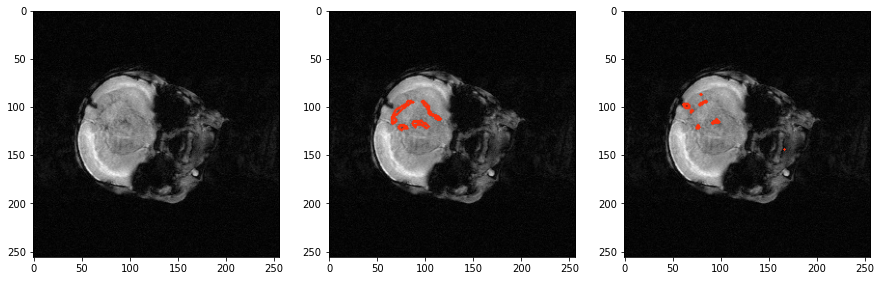

Cahnnel: 12
Cahnnel: 13
6


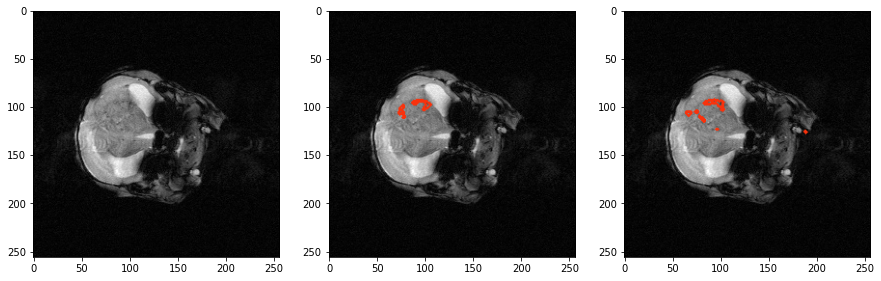

Cahnnel: 14
4


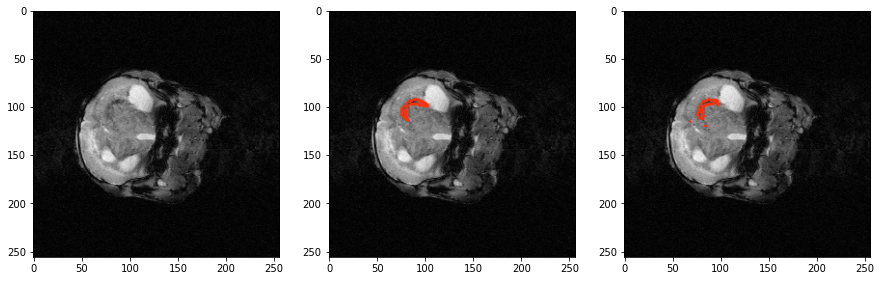

Cahnnel: 15
Cahnnel: 16
Cahnnel: 17
Cahnnel: 18
Cahnnel: 19
Cahnnel: 20
Cahnnel: 21
/content/drive/MyDrive/CAR-T/CAR-T_original_mask_trials/dataset_02/original images/test/C101M4D3_TE16.nii.gz
Cahnnel: 0
Cahnnel: 1
Cahnnel: 2
Cahnnel: 3
Cahnnel: 4
Cahnnel: 5
Cahnnel: 6
Cahnnel: 7
Cahnnel: 8
Cahnnel: 9
Cahnnel: 10
Cahnnel: 11
8


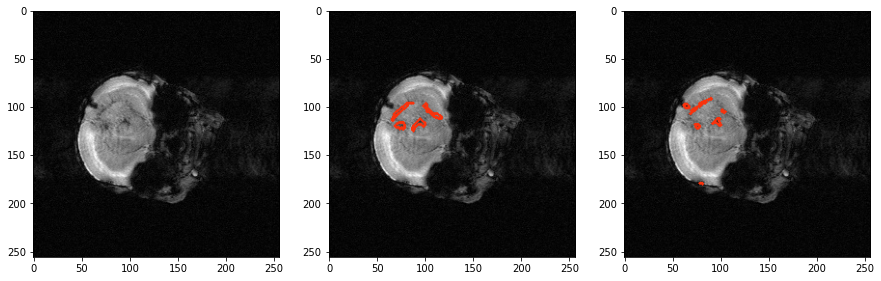

Cahnnel: 12
7


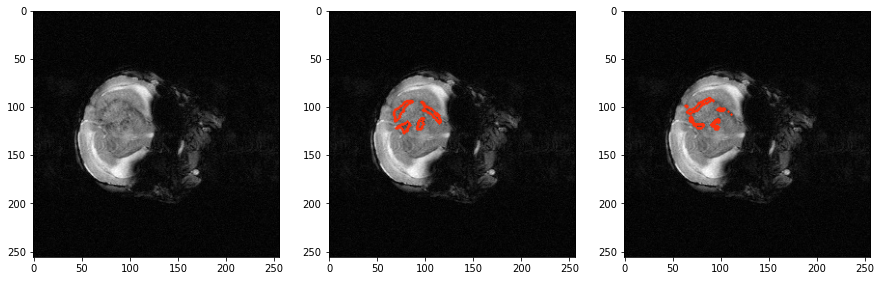

Cahnnel: 13
5


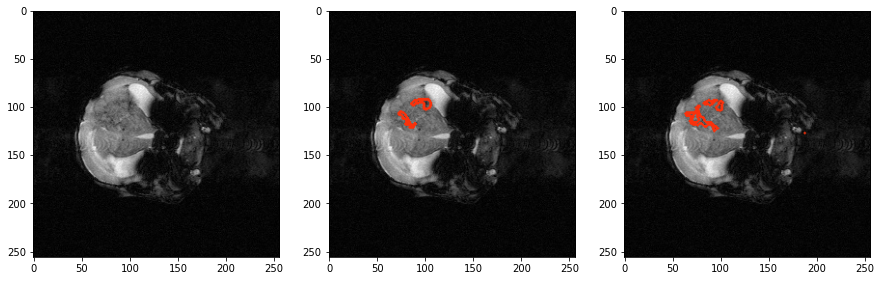

Cahnnel: 14
4


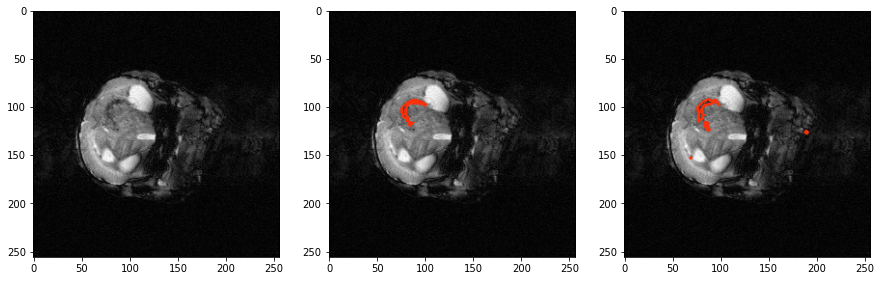

Cahnnel: 15
Cahnnel: 16
Cahnnel: 17
Cahnnel: 18
Cahnnel: 19
Cahnnel: 20
Cahnnel: 21
/content/drive/MyDrive/CAR-T/CAR-T_original_mask_trials/dataset_02/original images/test/C101M4D3_TE20.nii.gz
Cahnnel: 0
Cahnnel: 1
Cahnnel: 2
Cahnnel: 3
Cahnnel: 4
Cahnnel: 5
Cahnnel: 6
Cahnnel: 7
Cahnnel: 8
Cahnnel: 9
Cahnnel: 10
4


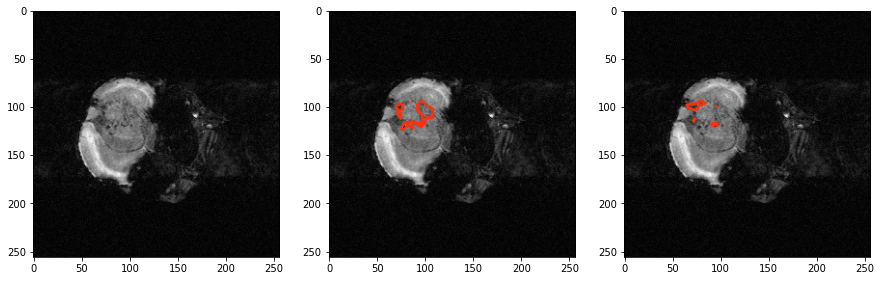

Cahnnel: 11
8


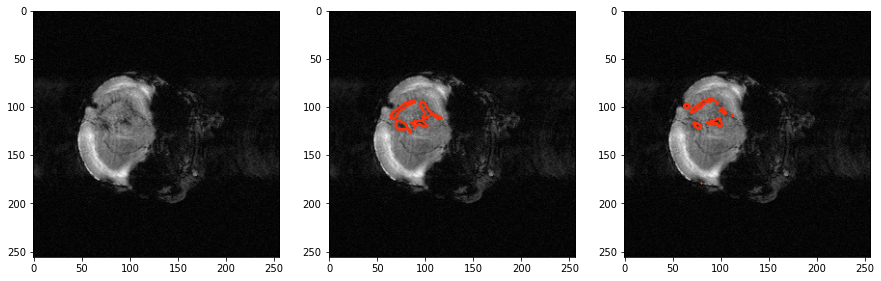

Cahnnel: 12
4


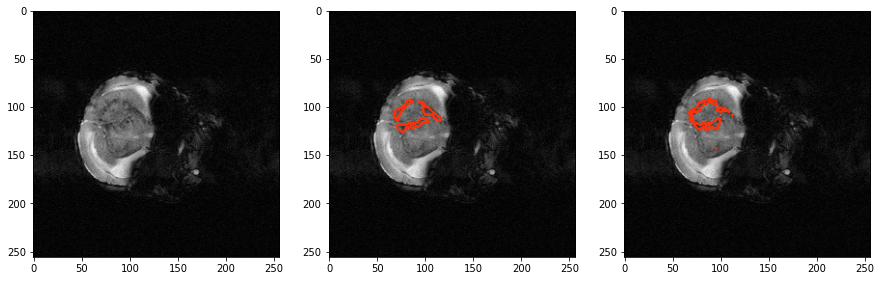

Cahnnel: 13
4


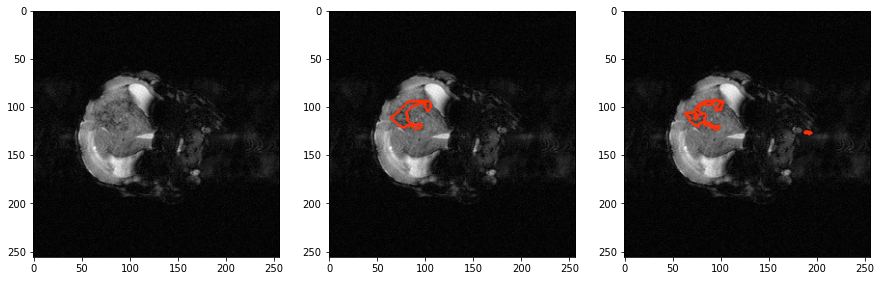

Cahnnel: 14
8


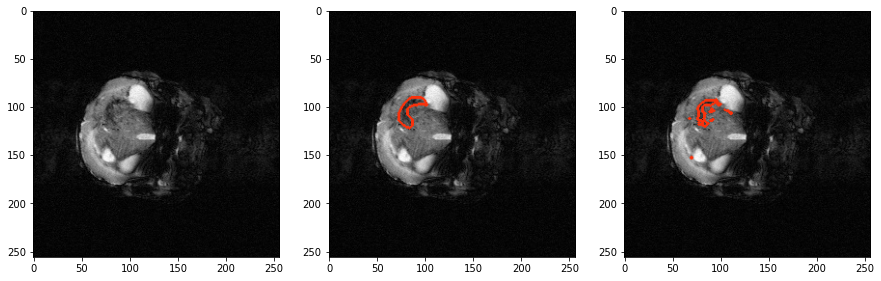

Cahnnel: 15
Cahnnel: 16
Cahnnel: 17
Cahnnel: 18
Cahnnel: 19
Cahnnel: 20
Cahnnel: 21
/content/drive/MyDrive/CAR-T/CAR-T_original_mask_trials/dataset_02/original images/test/C101M4D3_TE25.nii.gz
Cahnnel: 0
Cahnnel: 1
Cahnnel: 2
Cahnnel: 3
Cahnnel: 4
Cahnnel: 5
Cahnnel: 6
Cahnnel: 7
Cahnnel: 8
Cahnnel: 9
Cahnnel: 10
7


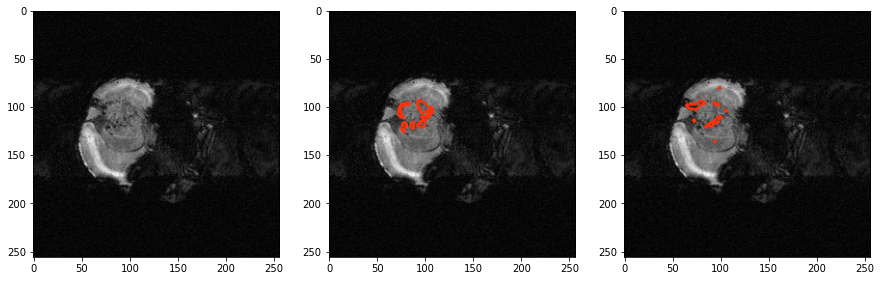

Cahnnel: 11
7


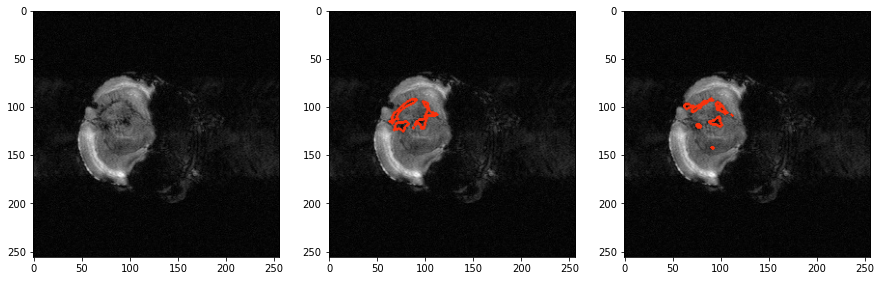

Cahnnel: 12
3


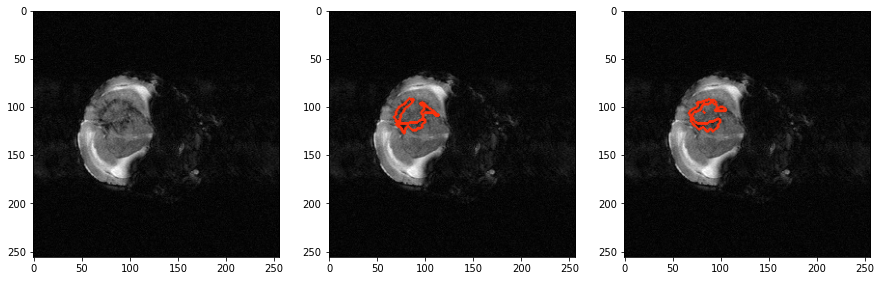

Cahnnel: 13
6


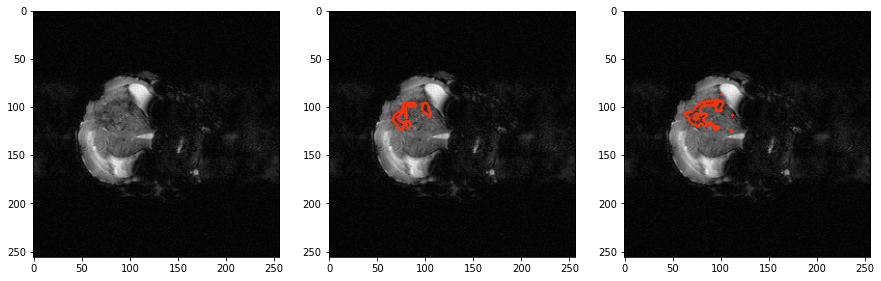

Cahnnel: 14
7


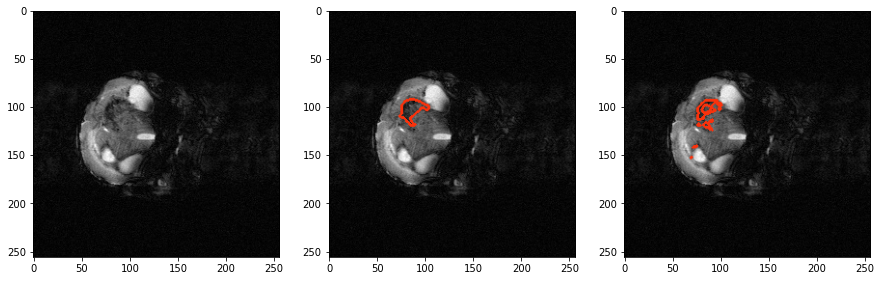

Cahnnel: 15
Cahnnel: 16
Cahnnel: 17
Cahnnel: 18
Cahnnel: 19
Cahnnel: 20
Cahnnel: 21
/content/drive/MyDrive/CAR-T/CAR-T_original_mask_trials/dataset_02/original images/test/C101M4D3_TE29.nii.gz
Cahnnel: 0
Cahnnel: 1
Cahnnel: 2
Cahnnel: 3
Cahnnel: 4
Cahnnel: 5
Cahnnel: 6
Cahnnel: 7
Cahnnel: 8
Cahnnel: 9
Cahnnel: 10
5


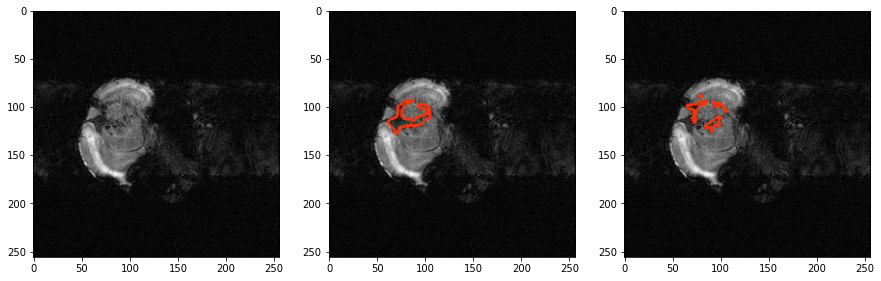

Cahnnel: 11
10


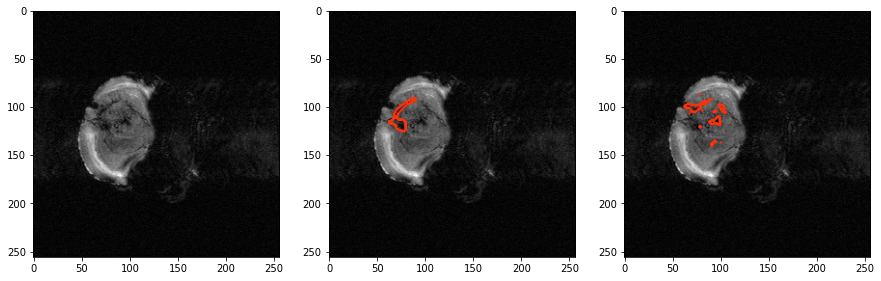

Cahnnel: 12
3


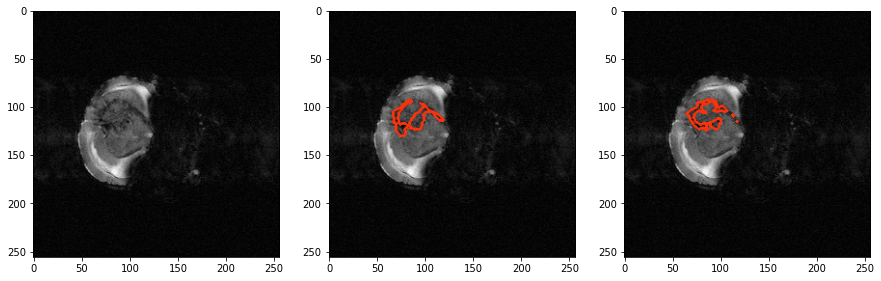

Cahnnel: 13
7


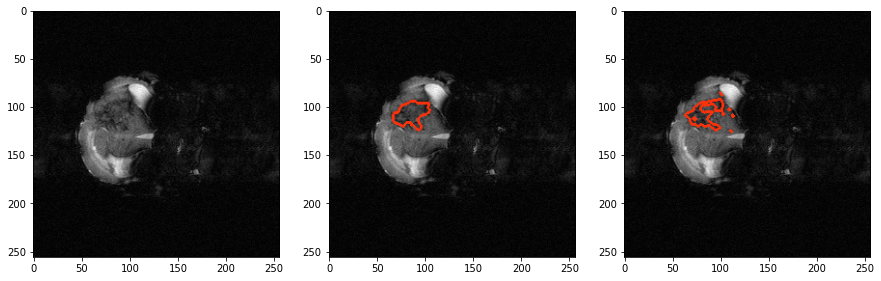

Cahnnel: 14
5


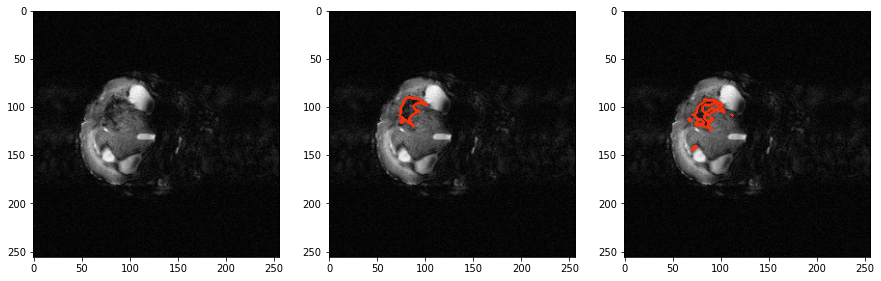

Cahnnel: 15
Cahnnel: 16
Cahnnel: 17
Cahnnel: 18
Cahnnel: 19
Cahnnel: 20
Cahnnel: 21
/content/drive/MyDrive/CAR-T/CAR-T_original_mask_trials/dataset_02/original images/test/C101M4D3_TE7.nii.gz
Cahnnel: 0
Cahnnel: 1
Cahnnel: 2
Cahnnel: 3
Cahnnel: 4
Cahnnel: 5
Cahnnel: 6
Cahnnel: 7
Cahnnel: 8
Cahnnel: 9
Cahnnel: 10
2


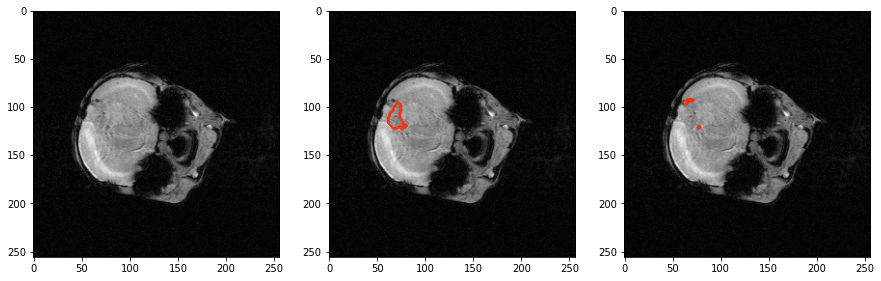

Cahnnel: 11
4


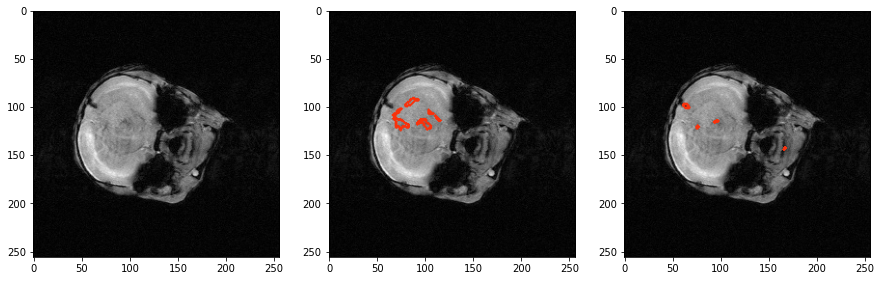

Cahnnel: 12
6


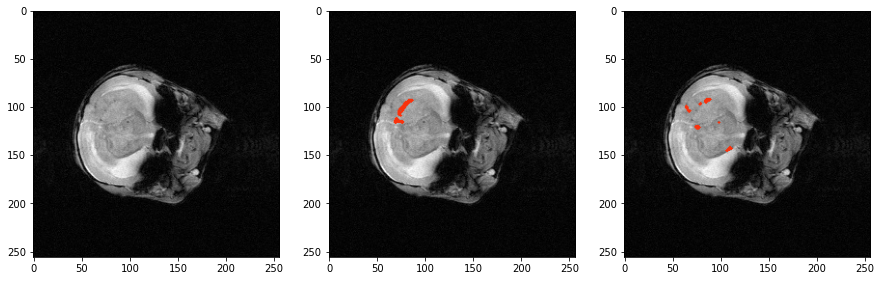

Cahnnel: 13
5


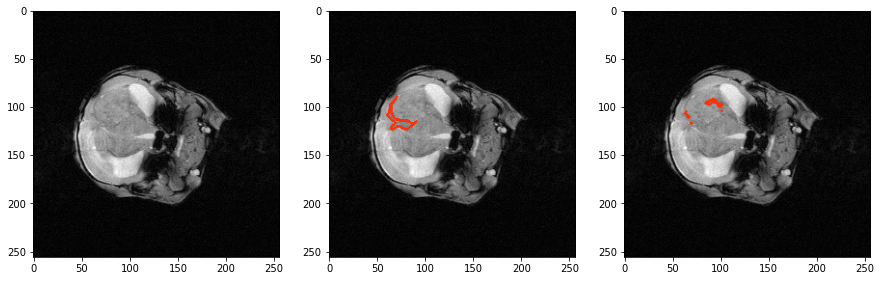

Cahnnel: 14
Cahnnel: 15
Cahnnel: 16
Cahnnel: 17
Cahnnel: 18
Cahnnel: 19
Cahnnel: 20
Cahnnel: 21
/content/drive/MyDrive/CAR-T/CAR-T_original_mask_trials/dataset_02/original images/test/C101M4D5_TE12.nii.gz
Cahnnel: 0
Cahnnel: 1
Cahnnel: 2
Cahnnel: 3
Cahnnel: 4
Cahnnel: 5
Cahnnel: 6
Cahnnel: 7
Cahnnel: 8
Cahnnel: 9
Cahnnel: 10
Cahnnel: 11
4


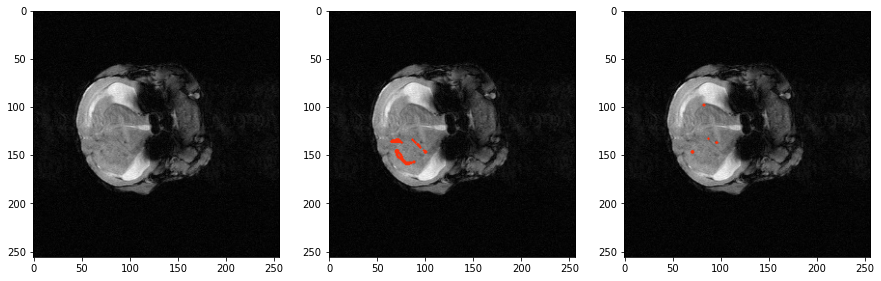

Cahnnel: 12
6


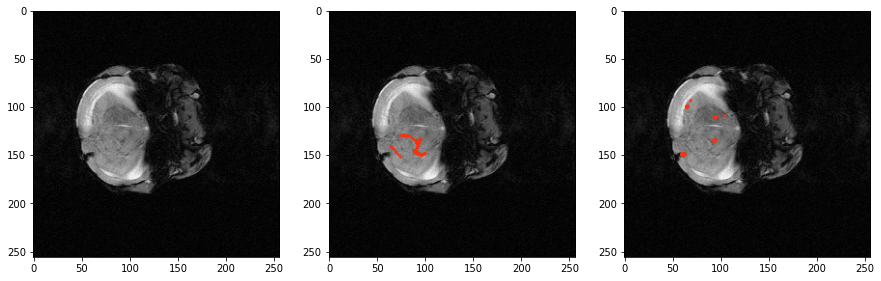

Cahnnel: 13
5


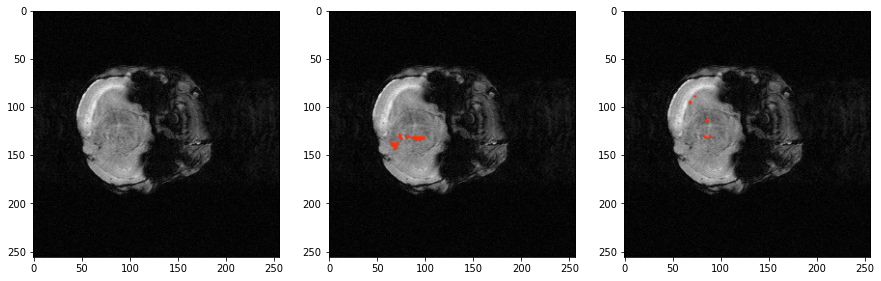

Cahnnel: 14
Cahnnel: 15
Cahnnel: 16
Cahnnel: 17
Cahnnel: 18
Cahnnel: 19
Cahnnel: 20
Cahnnel: 21
/content/drive/MyDrive/CAR-T/CAR-T_original_mask_trials/dataset_02/original images/test/C101M4D5_TE16.nii.gz
Cahnnel: 0
Cahnnel: 1
Cahnnel: 2
Cahnnel: 3
Cahnnel: 4
Cahnnel: 5
Cahnnel: 6
Cahnnel: 7
Cahnnel: 8
Cahnnel: 9
Cahnnel: 10
Cahnnel: 11
9


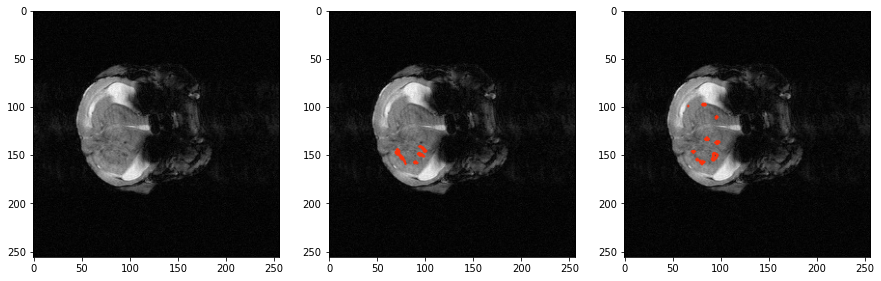

Cahnnel: 12
6


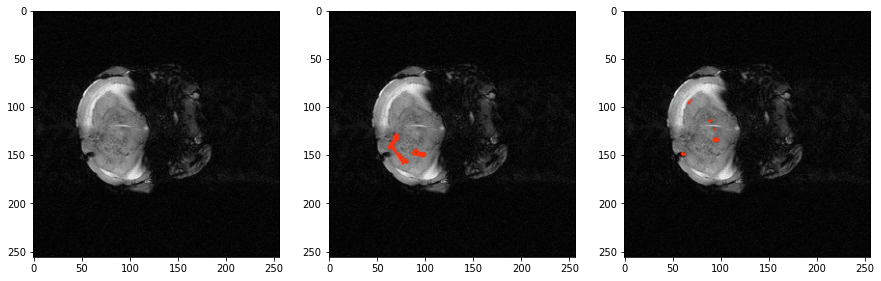

Cahnnel: 13
6


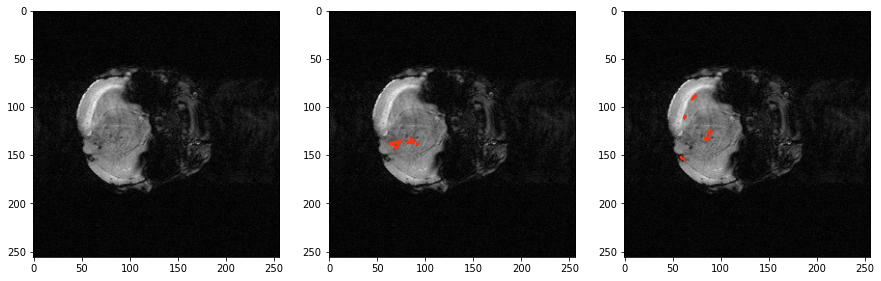

Cahnnel: 14
Cahnnel: 15
Cahnnel: 16
Cahnnel: 17
Cahnnel: 18
Cahnnel: 19
Cahnnel: 20
Cahnnel: 21
/content/drive/MyDrive/CAR-T/CAR-T_original_mask_trials/dataset_02/original images/test/C101M4D5_TE20.nii.gz
Cahnnel: 0
Cahnnel: 1
Cahnnel: 2
Cahnnel: 3
Cahnnel: 4
Cahnnel: 5
Cahnnel: 6
Cahnnel: 7
Cahnnel: 8
Cahnnel: 9
Cahnnel: 10
Cahnnel: 11
6


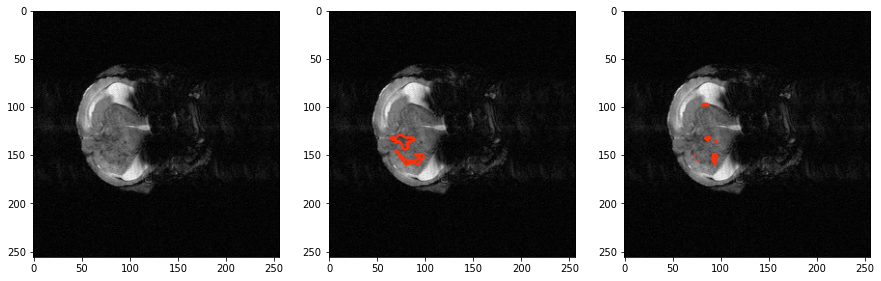

Cahnnel: 12
5


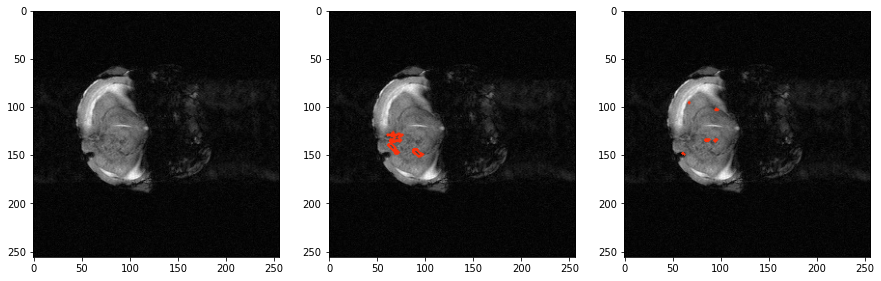

Cahnnel: 13
3


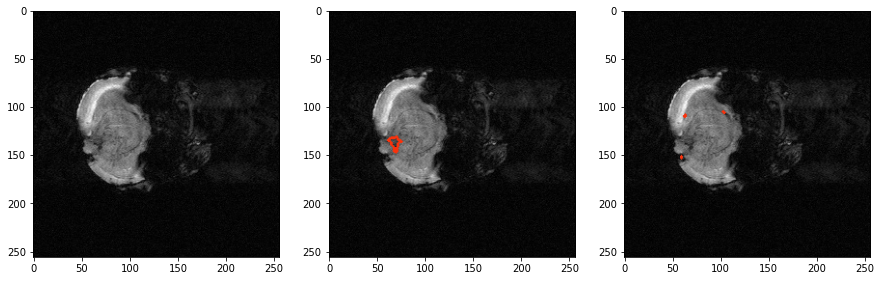

Cahnnel: 14
Cahnnel: 15
Cahnnel: 16
Cahnnel: 17
Cahnnel: 18
Cahnnel: 19
Cahnnel: 20
Cahnnel: 21
/content/drive/MyDrive/CAR-T/CAR-T_original_mask_trials/dataset_02/original images/test/C101M4D5_TE24.nii.gz
Cahnnel: 0
Cahnnel: 1
Cahnnel: 2
Cahnnel: 3
Cahnnel: 4
Cahnnel: 5
Cahnnel: 6
Cahnnel: 7
Cahnnel: 8
Cahnnel: 9
Cahnnel: 10
Cahnnel: 11
10


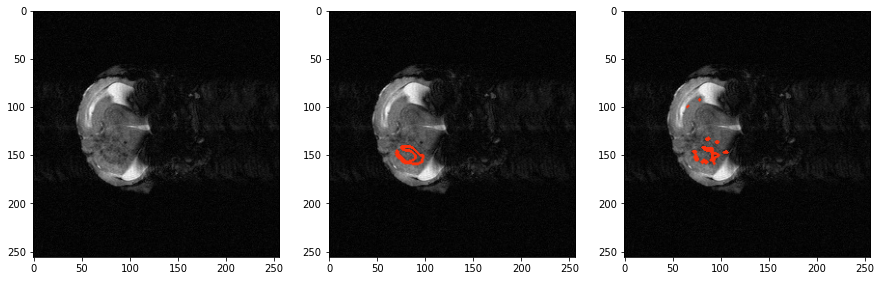

Cahnnel: 12
Cahnnel: 13
5


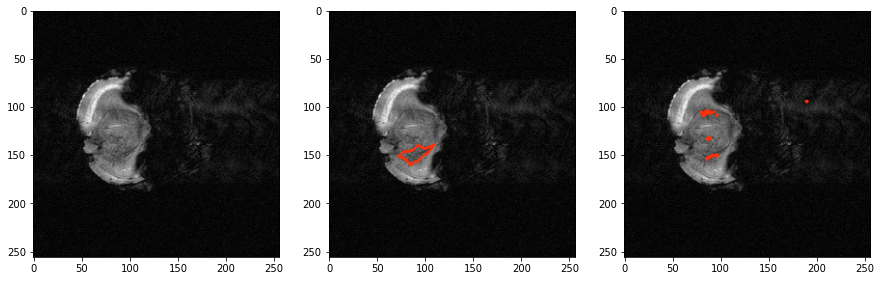

Cahnnel: 14
7


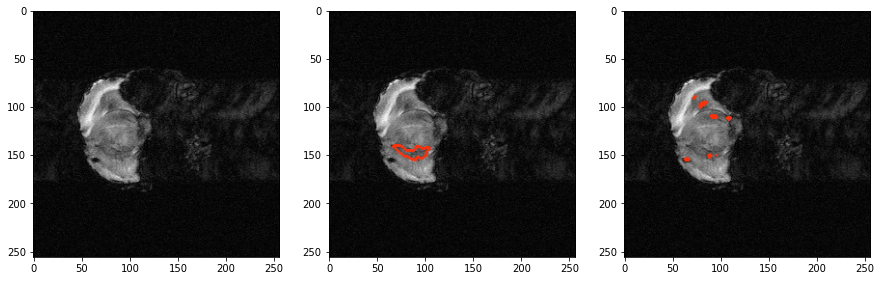

Cahnnel: 15
Cahnnel: 16
Cahnnel: 17
Cahnnel: 18
Cahnnel: 19
Cahnnel: 20
Cahnnel: 21
/content/drive/MyDrive/CAR-T/CAR-T_original_mask_trials/dataset_02/original images/test/C101M4D5_TE29.nii.gz
Cahnnel: 0
Cahnnel: 1
Cahnnel: 2
Cahnnel: 3
Cahnnel: 4
Cahnnel: 5
Cahnnel: 6
Cahnnel: 7
Cahnnel: 8
Cahnnel: 9
Cahnnel: 10
Cahnnel: 11
Cahnnel: 12
Cahnnel: 13
2


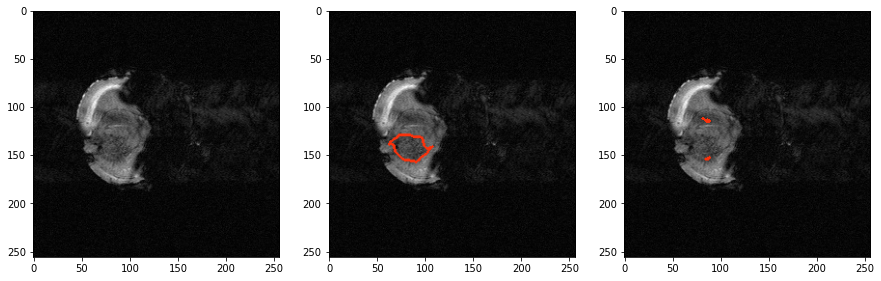

Cahnnel: 14
6


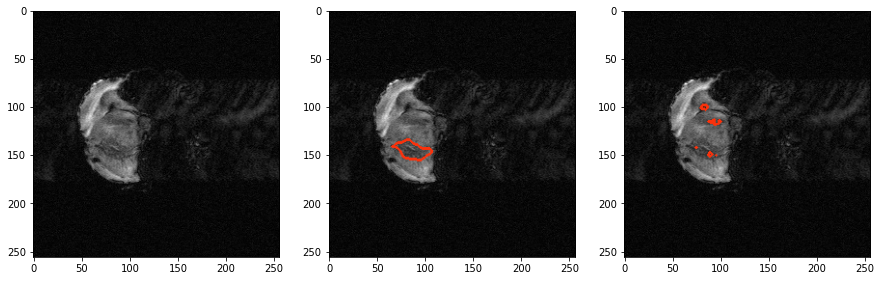

Cahnnel: 15
5


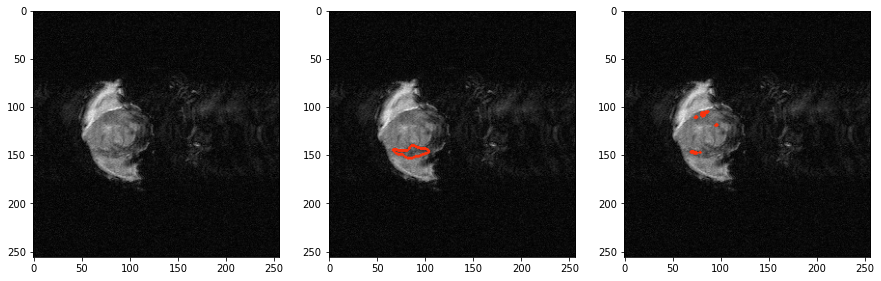

Cahnnel: 16
Cahnnel: 17
Cahnnel: 18
Cahnnel: 19
Cahnnel: 20
Cahnnel: 21
/content/drive/MyDrive/CAR-T/CAR-T_original_mask_trials/dataset_02/original images/test/C101M4D5_TE7.nii.gz
Cahnnel: 0
Cahnnel: 1
Cahnnel: 2
Cahnnel: 3
Cahnnel: 4
Cahnnel: 5
Cahnnel: 6
Cahnnel: 7
Cahnnel: 8
Cahnnel: 9
Cahnnel: 10
Cahnnel: 11
Cahnnel: 12
Cahnnel: 13
3


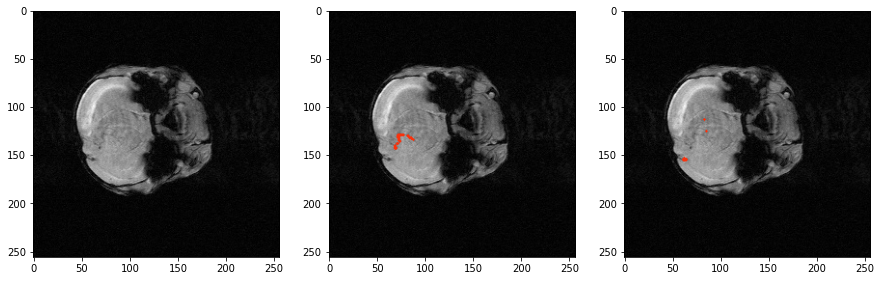

Cahnnel: 14
Cahnnel: 15
Cahnnel: 16
Cahnnel: 17
Cahnnel: 18
Cahnnel: 19
Cahnnel: 20
Cahnnel: 21


In [ ]:
k = 0
for ID in range(0,len(test_df)):
  img_path = test_df['images'].iloc[ID]
  print(img_path )
  img = load_image(img_path)
  msk_path = test_df['labels'].iloc[ID]
  msk = load_image(msk_path)

  for channel in range(0,n_channels):
    print("Cahnnel:",channel)
    y0 = prediction[k].reshape(256,256)
    y = np.where(y0 > 0.5, 1, y0)
    k+=1
    if  np.sum(msk[:,:,channel]) > 0: # if labeled
      show_mask_image(img[:,:,channel], msk[:,:,channel], y)
